In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

In [2]:
with open('results/summit/summaries.json') as f:
    summaries = json.load(f)

In [3]:
summaries = {tuple(v.pop('name')): v for v in summaries.values()}

In [24]:
list(summaries.keys())

[('cms2018+field+msc', 'vecgeom', 'cpu'),
 ('cms2018+field+msc', 'vecgeom', 'gpu'),
 ('cms2018', 'vecgeom', 'cpu'),
 ('cms2018', 'vecgeom', 'gpu'),
 ('simple-cms+field+msc', 'orange', 'cpu'),
 ('simple-cms+field+msc', 'orange', 'gpu'),
 ('simple-cms+field+msc', 'vecgeom', 'cpu'),
 ('simple-cms+field+msc', 'vecgeom', 'gpu'),
 ('simple-cms+field', 'orange', 'cpu'),
 ('simple-cms+field', 'orange', 'gpu'),
 ('simple-cms+msc', 'orange', 'cpu'),
 ('simple-cms+msc', 'orange', 'gpu'),
 ('testem15+field+msc', 'orange', 'cpu'),
 ('testem15+field+msc', 'orange', 'gpu'),
 ('testem15+field+msc', 'vecgeom', 'cpu'),
 ('testem15+field+msc', 'vecgeom', 'gpu'),
 ('testem15+field', 'orange', 'cpu'),
 ('testem15+field', 'orange', 'gpu'),
 ('testem15', 'orange', 'cpu'),
 ('testem15', 'orange', 'gpu'),
 ('testem3-flat+field', 'orange', 'cpu'),
 ('testem3-flat+field', 'orange', 'gpu'),
 ('testem3-flat+msc', 'orange', 'cpu'),
 ('testem3-flat+msc', 'orange', 'gpu'),
 ('testem3-flat', 'orange', 'cpu'),
 ('teste

In [4]:
results = pd.DataFrame([v['result'] for v in summaries.values()],
                       index=summaries.keys())

In [5]:
def unstack_subdict(df):
    result = pd.DataFrame(list(df.values), index=df.index)
    result.columns.name = df.name
    return result

In [6]:
full_results = results.stack()
full_results.index.names = ['problem', 'geo', 'arch', 'instance']
full_results = unstack_subdict(full_results)

In [7]:
invalid = np.isnan(full_results['avg_time_per_primary'])

In [8]:
full_results.index[invalid]

MultiIndex([('simple-cms+field+msc',  'orange', 'cpu', 0),
            ('simple-cms+field+msc',  'orange', 'cpu', 1),
            ('simple-cms+field+msc',  'orange', 'cpu', 2),
            ('simple-cms+field+msc',  'orange', 'cpu', 3),
            ('simple-cms+field+msc',  'orange', 'cpu', 4),
            ('simple-cms+field+msc',  'orange', 'cpu', 5),
            ('simple-cms+field+msc',  'orange', 'gpu', 0),
            ('simple-cms+field+msc',  'orange', 'gpu', 1),
            ('simple-cms+field+msc',  'orange', 'gpu', 2),
            ('simple-cms+field+msc',  'orange', 'gpu', 3),
            ('simple-cms+field+msc',  'orange', 'gpu', 4),
            ('simple-cms+field+msc',  'orange', 'gpu', 5),
            (    'simple-cms+field',  'orange', 'cpu', 0),
            (    'simple-cms+field',  'orange', 'cpu', 1),
            (    'simple-cms+field',  'orange', 'cpu', 2),
            (    'simple-cms+field',  'orange', 'cpu', 3),
            (    'simple-cms+field',  'orange', 'cpu', 4

In [9]:
def summarize_instances(df):
    """TODO: probably a better way to do this with a combination of stack/unstack"""
    transformed = {}
    for k in df.columns:
        temp = df[k].unstack().T.describe().T[['count', 'mean', 'std']]
        temp.columns.name = k
        transformed[temp.columns.name] = temp
    result = pd.concat(transformed, axis=1, names=[df.columns.name, "summary"])
    return result

In [10]:
action_times = summarize_instances(unstack_subdict(full_results['action_times'][~invalid]))

In [11]:
full_results.keys()

Index(['action_times', 'active_hwm', 'avg_steps_per_primary',
       'avg_time_per_primary', 'avg_time_per_step', 'emptying_step',
       'num_primaries', 'num_step_iters', 'num_steps', 'pre_emptying_time',
       'queue_hwm', 'total_time', 'unconverged', 'exception', 'failure'],
      dtype='object')

In [12]:
summed = summarize_instances(full_results[['avg_steps_per_primary',
       'avg_time_per_primary', 'avg_time_per_step', 'num_steps', 'total_time', 'unconverged']])

In [13]:
summed.xs('mean', axis=1, level='summary')

avg_steps_per_primary  \
problem              geo     arch                          
cms2018              vecgeom cpu            10088.901164   
                             gpu             4114.109383   
cms2018+field+msc    vecgeom cpu           524288.000000   
                             gpu            10233.794083   
simple-cms+field     orange  cpu                     NaN   
                             gpu                     NaN   
simple-cms+field+msc orange  cpu                     NaN   
                             gpu                     NaN   
                     vecgeom cpu             6969.623169   
                             gpu             2826.762183   
simple-cms+msc       orange  cpu             6879.932373   
                             gpu             2818.600433   
testem15             orange  cpu               46.485392   
                             gpu               19.037267   
testem15+field       orange  cpu               46.306519   
                             gpu               19.015150   
testem15+field+msc   orange  cpu               46.455973   
                             gpu               19.016683   
                     vecgeom cpu               46.455973   
                             gpu               19.016683   
testem3-flat         orange  cpu           112504.021037   
                             gpu                     NaN   
                     vecgeom cpu           112504.021037   
                             gpu                     NaN   
testem3-flat+field   orange  cpu           112546.124390   
                             gpu                     NaN   
testem3-flat+msc     orange  cpu           149644.703796   
                             gpu                     NaN   

                                   avg_time_per_primary  avg_time_per_step  \
problem              geo     arch                                            
cms2018              vecgeom cpu               0.003469       3.438780e-07   
                             gpu               0.000319       7.755734e-08   
cms2018+field+msc    vecgeom cpu               0.379878       7.245605e-07   
                             gpu               0.002426       2.370628e-07   
simple-cms+field     orange  cpu                    NaN                NaN   
                             gpu                    NaN                NaN   
simple-cms+field+msc orange  cpu                    NaN                NaN   
                             gpu                    NaN                NaN   
                     vecgeom cpu               0.005912       8.434909e-07   
                             gpu               0.000524       1.854678e-07   
simple-cms+msc       orange  cpu               0.002188       3.180404e-07   
                             gpu               0.000055       1.938711e-08   
testem15             orange  cpu               0.000019       3.982367e-07   
                             gpu               0.000018       9.706543e-07   
testem15+field       orange  cpu               0.000019       4.143273e-07   
                             gpu               0.000015       7.731015e-07   
testem15+field+msc   orange  cpu               0.000025       5.465431e-07   
                             gpu               0.000015       7.673521e-07   
                     vecgeom cpu               0.000025       5.373584e-07   
                             gpu               0.000016       8.218492e-07   
testem3-flat         orange  cpu               0.024166       2.147991e-07   
                             gpu                    NaN                NaN   
                     vecgeom cpu               0.022874       2.033193e-07   
                             gpu                    NaN                NaN   
testem3-flat+field   orange  cpu               0.033403       2.967958e-07   
                             gpu                    NaN                NaN   
testem3-flat+msc     orange  cpu               0.0

In [14]:
summed['avg_time_per_step']

summary                            count          mean           std
problem              geo     arch                                   
cms2018              vecgeom cpu     6.0  3.438780e-07  2.957086e-09
                             gpu     6.0  7.755734e-08  4.509881e-09
cms2018+field+msc    vecgeom cpu     6.0  7.245605e-07  4.956472e-09
                             gpu     6.0  2.370628e-07  1.499567e-08
simple-cms+field     orange  cpu     0.0           NaN           NaN
                             gpu     0.0           NaN           NaN
simple-cms+field+msc orange  cpu     0.0           NaN           NaN
                             gpu     0.0           NaN           NaN
                     vecgeom cpu     6.0  8.434909e-07  4.702329e-07
                             gpu     6.0  1.854678e-07  2.790581e-08
simple-cms+msc       orange  cpu     6.0  3.180404e-07  3.337205e-09
                             gpu     6.0  1.938711e-08  1.149823e-09
testem15             orange  cpu     6.0  3.982367e-07  4.013834e-09
                             gpu     6.0  9.706543e-07  8.453593e-09
testem15+field       orange  cpu     6.0  4.143273e-07  1.414108e-08
                             gpu     6.0  7.731015e-07  1.755451e-07
testem15+field+msc   orange  cpu     6.0  5.465431e-07  1.017228e-08
                             gpu     6.0  7.673521e-07  2.190817e-07
                     vecgeom cpu     6.0  5.373584e-07  1.942605e-09
                             gpu     6.0  8.218492e-07  9.844708e-09
testem3-flat         orange  cpu     6.0  2.147991e-07  9.049413e-10
                             gpu     0.0           NaN           NaN
                     vecgeom cpu     6.0  2.033193e-07  1.184404e-09
                             gpu     0.0           NaN           NaN
testem3-flat+field   orange  cpu     2.0  2.967958e-07  1.643813e-10
                             gpu     0.0           NaN           NaN
testem3-flat+msc     orange  cpu     4.0  3.494431e-07  5.038007e-09
                             gpu     0.0           NaN           NaN

In [15]:
def get_cpugpu_ratio(summary):
    mean = summary['mean'].unstack()
    rel  = (summary['std'] / summary['mean']).unstack()
    ratio = mean['cpu'] / mean['gpu']
    rel_err = np.sqrt(rel['cpu']**2 + rel['gpu']**2)
    return pd.DataFrame({'ratio': ratio, 're': rel_err})

In [16]:
get_cpugpu_ratio(summed['avg_time_per_step'])

ratio        re
problem              geo                         
cms2018              vecgeom   4.433855  0.058781
cms2018+field+msc    vecgeom   3.056407  0.063625
simple-cms+field     orange         NaN       NaN
simple-cms+field+msc orange         NaN       NaN
                     vecgeom   4.547910  0.577432
simple-cms+msc       orange   16.404736  0.060230
testem15             orange    0.410277  0.013321
testem15+field       orange    0.535929  0.229617
testem15+field+msc   orange    0.712246  0.286109
                     vecgeom   0.653841  0.012512
testem3-flat         orange         NaN       NaN
                     vecgeom        NaN       NaN
testem3-flat+field   orange         NaN       NaN
testem3-flat+msc     orange         NaN       NaN

In [17]:
active_hwm = summarize_instances(unstack_subdict(full_results['active_hwm'][~invalid]))

In [18]:
active_hwm

active_hwm                        count                             index  \
summary                           count           mean          std count   
problem              geo     arch                                           
cms2018+field+msc    vecgeom cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0  428186.833333   816.844518   6.0   
cms2018              vecgeom cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0  348380.000000  1103.369023   6.0   
simple-cms+field+msc vecgeom cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0  524288.000000     0.000000   6.0   
simple-cms+msc       orange  cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0  524288.000000     0.000000   6.0   
testem15+field+msc   orange  cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0   30184.000000   134.198361   6.0   
                     vecgeom cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0   30184.000000   134.198361   6.0   
testem15+field       orange  cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0   30186.166667   115.262165   6.0   
testem15             orange  cpu    6.0    4096.000000     0.000000   6.0   
                             gpu    6.0   30230.000000   176.606908   6.0   
testem3-flat+field   orange  cpu    2.0    4096.000000     0.000000   2.0   
testem3-flat+msc     orange  cpu    4.0    4096.000000     0.000000   4.0   
testem3-flat         orange  cpu    6.0    4096.000000     0.000000   6.0   
                     vecgeom cpu    6.0    4096.000000     0.000000   6.0   

active_hwm                                                    
summary                                     mean         std  
problem              geo     arch                             
cms2018+field+msc    vecgeom cpu   524287.000000    0.000000  
                             gpu      384.833333    0.752773  
cms2018              vecgeom cpu    10047.666667  101.200132  
                             gpu      377.500000    0.836660  
simple-cms+field+msc vecgeom cpu     6879.000000    8.809086  
                             gpu       53.000000    0.000000  
simple-cms+msc       orange  cpu     6860.666667    5.715476  
                             gpu       53.000000    0.000000  
testem15+field+msc   orange  cpu       41.000000    0.000000  
                             gpu        4.000000    0.000000  
                     vecgeom cpu       41.000000    0.000000  
                             gpu        4.000000    0.000000  
testem15+field       orange  cpu       40.666667    0.516398  
                             gpu        4.000000    0.000000  
testem15             orange  cpu       40.666667    0.516398  
                             gpu        4.000000    0.000000  
testem3-flat+field   orange  cpu   112492.500000    6.363961  
testem3-flat+msc     orange  cpu   149580.000000   23.137272  
testem3-flat         orange  cpu   112449.000000   13.564660  
                     vecgeom cpu   112449.000000   13.564660

In [19]:
summed[['num_steps', 'unconverged']].xs('mean', axis=1, level='summary')

num_steps   unconverged
problem              geo     arch                            
cms2018              vecgeom cpu   4.132414e+07      0.000000
                             gpu   4.114109e+07      0.000000
cms2018+field+msc    vecgeom cpu   2.147484e+09   5877.166667
                             gpu   1.023379e+08  10495.500000
simple-cms+field     orange  cpu            NaN           NaN
                             gpu            NaN           NaN
simple-cms+field+msc orange  cpu            NaN           NaN
                             gpu            NaN           NaN
                     vecgeom cpu   2.854758e+07      0.166667
                             gpu   2.826762e+07      3.000000
simple-cms+msc       orange  cpu   2.818020e+07      0.000000
                             gpu   2.818600e+07      0.000000
testem15             orange  cpu   1.904042e+05      0.000000
                             gpu   1.903727e+05      0.000000
testem15+field       orange  cpu   1.896715e+05      0.000000
                             gpu   1.901515e+05      0.000000
testem15+field+msc   orange  cpu   1.902837e+05      0.000000
                             gpu   1.901668e+05      0.000000
                     vecgeom cpu   1.902837e+05      0.000000
                             gpu   1.901668e+05      0.000000
testem3-flat         orange  cpu   4.608165e+08      0.000000
                             gpu            NaN           NaN
                     vecgeom cpu   4.608165e+08      0.000000
                             gpu            NaN           NaN
testem3-flat+field   orange  cpu   4.609889e+08      0.000000
                             gpu            NaN           NaN
testem3-flat+msc     orange  cpu   6.129447e+08      0.000000
                             gpu            NaN           NaN

In [20]:
def plot_counts(ax, out):
    blue = (.1, .1, .9)
    red = (.7, .1, .1)

    lines = []
    def plot(ax, *args, **kwargs):
        line, = ax.plot(*args, **kwargs)
        lines.append(line)

    plot(ax, out['result']['active'], '-', color=(blue + (0.5,)), label='Active')
    plot(ax, out['result']['alive'], '-', color=blue, label='Alive')
    ax.set_xlabel('Step iteration')
    ax.set_ylabel('Tracks', color=blue)

    oax = ax.twinx()
    inits = np.array(out['result']['initializers'])
    plot(oax, inits, '--', color=red, label='Queued')
    oax.axhline(out['input']['initializer_capacity'], linestyle='--', color=(red + (0.25,)))
    oax.set_ylabel('Initializers', color=red)

    max_init_idx = np.argmax(inits)
    max_init_val = inits[max_init_idx]
    text = re.sub(r'([-+.0-9]+)e\+?(-)?0*([0-9]+)', r'$\1\\times 10^{\2\3}$',
                  f'{max_init_val:.2g}')
    oax.annotate(text + ' queued', xy=(max_init_idx, max_init_val), xycoords='data',
                 xytext=(30, 10), textcoords='offset points',
                 size='x-small',
                 bbox=dict(boxstyle="round,pad=.2", fc=(0.9, 0.9, 0.9, 0.8) , ec=(0.2,)*3),
                 arrowprops=dict(arrowstyle="->", ec=red, lw=1,
                                 connectionstyle="arc3,rad=0.2"))

    oax.spines['left'].set_color(blue)
    oax.spines['right'].set_color(red)

    ax.legend(lines, [l.get_label() for l in lines])

    return {
        'ax': ax,
        'oax': oax,
    }

In [21]:
with open('results/summit/cms2018+field+msc-vecgeom-gpu/0.json') as f:
    full = json.load(f)

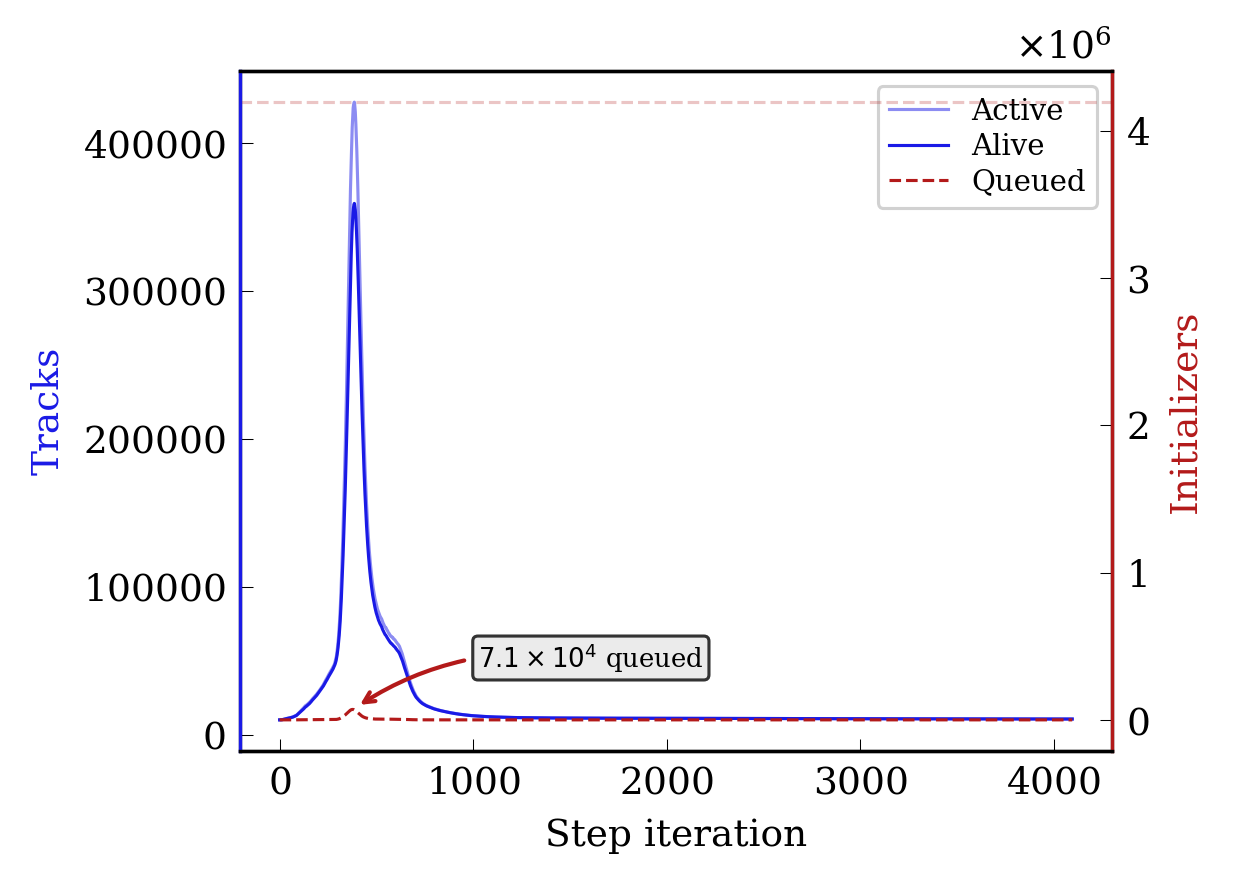

In [22]:
(fig, ax) = plt.subplots()
plot_counts(ax, full);